In [1]:

import numpy as np
from astropy.io import fits

import lina

import scoobpsf
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import *
import scoobpsf.compact_scoob as cscoob

import scoobpsf.custom_dm as cdm

from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

pupil_diam = 6.75*u.mm 
lyot_diam = 3.6*u.mm
det_rotation = -7.5 #  degrees of rotation of the detector relative to the optical axis

wavelength_c = 632.8e-9*u.m # central wavelength



# Initialize compact model for HOWFSC

In [2]:
reload(cscoob)
reload(cdm)
inf_fun = str('/home/kianmilani/Projects/scoob-psf/scoobpsf/bmc_inf.fits')

model = cscoob.SCOOB(npix=200, oversample=10, npsf=200,
                     inf_fun=inf_fun,
                     dm_fill_factor=0.94)


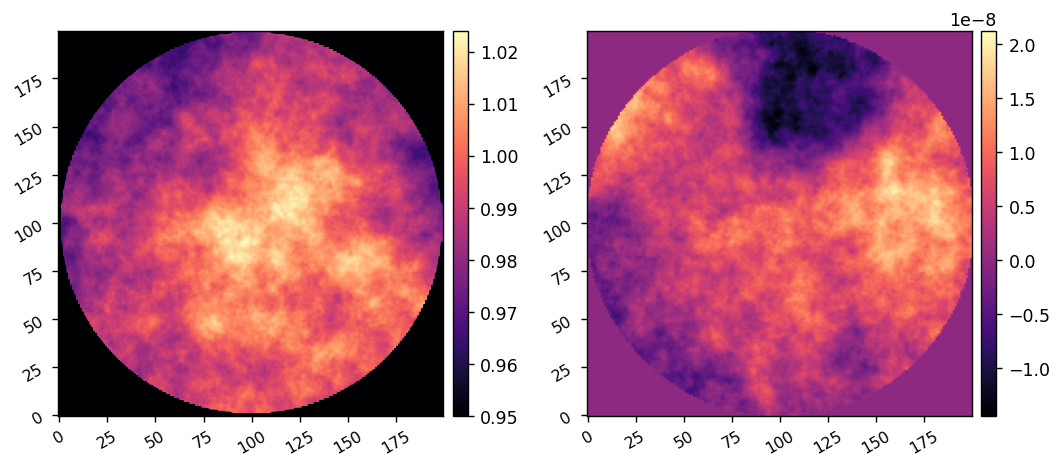

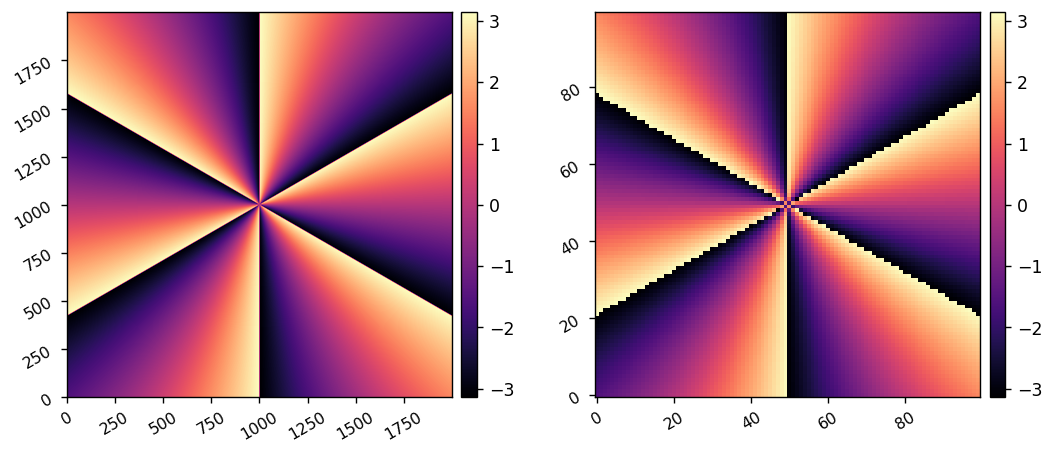

In [3]:
reload(cscoob)
WFE = cscoob.generate_wfe(diam=model.pupil_diam, distance=50*u.mm, 
                          amp_rms=0.025*u.nm, amp_index=3, amp_seed=1234,
                          opd_rms=10*u.nm, opd_index=3, opd_seed=2345,
                          npix=model.npix, oversample=model.oversample,)
model.WFE = WFE
imshow2(xp.abs(WFE), xp.angle(WFE)/(2*np.pi)*model.wavelength.to_value(u.m), 
        npix=model.npix,
        vmin1=0.95)

VC = cscoob.make_vortex_phase_mask(model.focal_grid_pol, charge=6, 
#                                    singularity=20*u.um, 
                                   focal_length=500*u.mm, pupil_diam=9.7*u.mm, wavelength=632.8*u.nm)
imshow2(xp.angle(VC), xp.angle(scoobpsf.utils.pad_or_crop(VC, 100)))
model.FPM = VC

LS = model.pupil_grid[0] < model.pupil_diam.to_value(u.m)/2 * 0.9
model.LYOT = LS

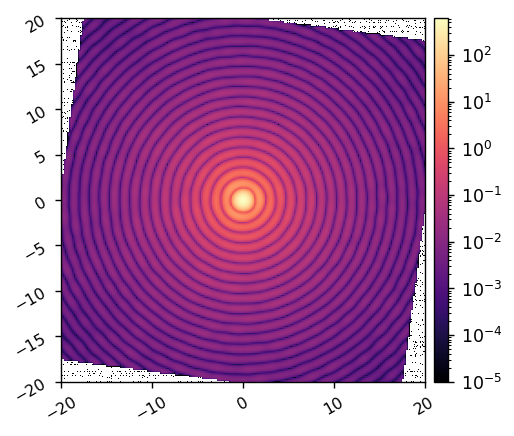

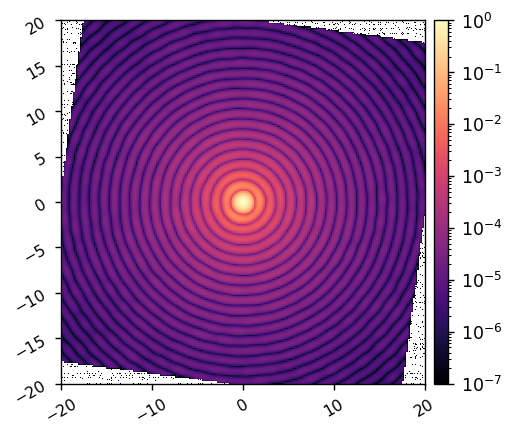

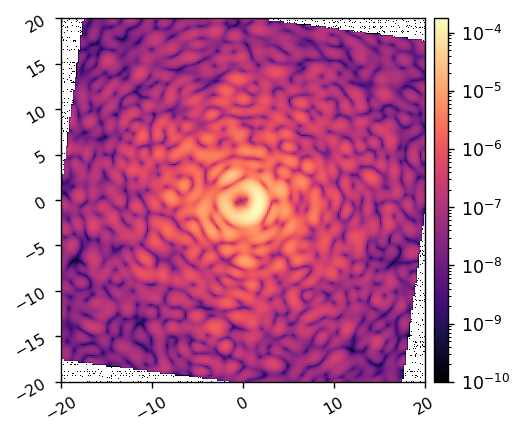

In [4]:
model.det_rotation = -7.5
model.npsf = 200
model.FPM = None

model.Imax_ref = None
ref_unocc_psf = model.snap(plot=True, vmin=1e-5)

model.Imax_ref = ref_unocc_psf.max()
ni_psf = model.snap(plot=True, vmin=1e-7)

model.FPM = VC
ref_im = model.snap(plot=True, vmin=1e-10)

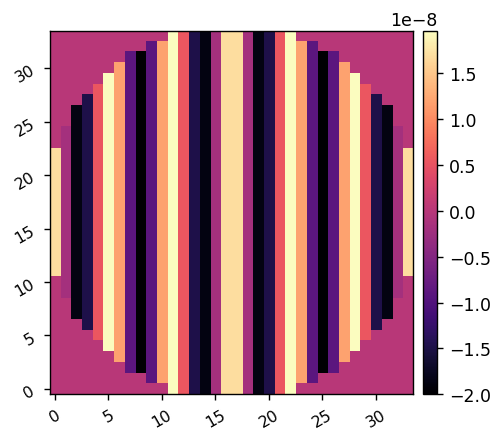

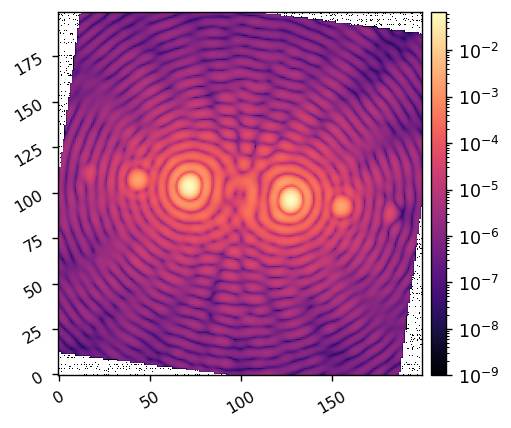

In [5]:
xpp = np.linspace(-model.Nact/2, model.Nact/2-1, model.Nact) + 1/2
ppx, ppy = np.meshgrid(xpp,xpp)

amp = 2e-8

x_sep = 6
y_sep = 0
command = amp*np.cos(2*np.pi*ppx*x_sep/model.Nact + 2*np.pi*ppy*y_sep/model.Nact)*model.dm_mask
imshow1(command)

model.add_dm(command)
test_im = model.snap()
model.reset_dm()

imshow1(test_im, lognorm=True, vmin=1e-9)

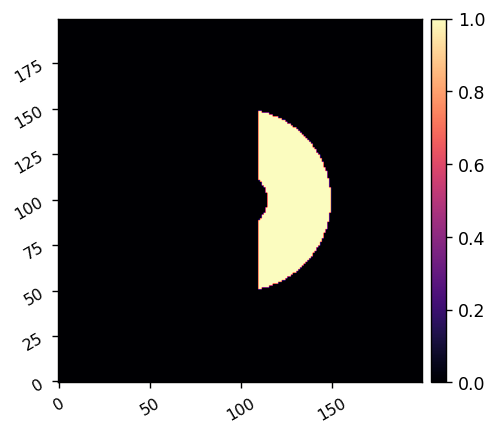

In [6]:
control_mask = (model.im_grid_pol[0] > 3)*(model.im_grid_pol[0] < 10)*(model.im_grid_car[0]>2)
imshow1(ensure_np_array(control_mask))

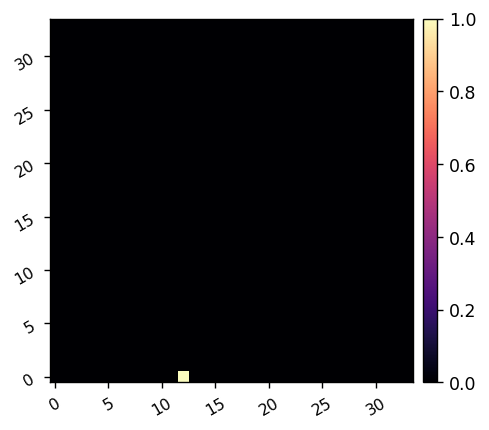

In [7]:
calib_amp = 1e-9
calib_modes = lina.utils.create_all_poke_modes(model.dm_mask)
imshow1(calib_modes[1].reshape(model.Nact, model.Nact))

In [23]:
model.reset_dm()

Calculating Jacobian: 
	Calculated response for mode 952/952. Elapsed time=130.804 sec.
Jacobian built in 130.804 sec


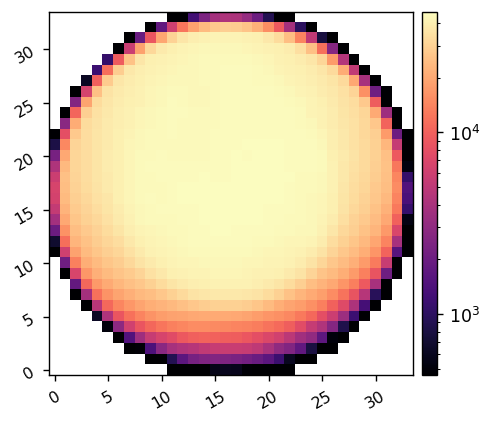

In [24]:
reload(lina.efc)
jac = lina.efc.build_jacobian(model, calib_modes, calib_amp, control_mask, plot=True)